# Hotel Bookings - Predicting Cancellations

### Data Cleaning and Transformations

#### First, we clean and transform the data based on the decisions made during the data exploration stage (detailed in the other notebook).

In [1]:
# libraries needed for cleaning and visualisations
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data=pd.read_csv("hotel_bookings.csv")

In [5]:
# encode dependent variable for classification
data['is_canceled'] = pd.Categorical(data['is_canceled']) 

#------------------ Clean the data and transform ---------------------------#

# cut under represented factor levels or split into binary

## Distribution channel

# TA/TO        0.819750
# Direct       0.122665
# Corporate    0.055926
# GDS          0.001617
# Undefined    0.000042

data = data[(data['distribution_channel'] == 'TA/TO') |
            (data['distribution_channel'] == 'Direct') |
            (data['distribution_channel'] == 'Corporate')] 

#---------------------------------#
## Rooms

# A    85446
# D    19161
# E     6470
# F     2890
# G     2083
# B     1114
# C      931
# H      601
# L        6
# P        2

# we clean room types P and L
data = data[(data['reserved_room_type'] != 'P') & (data['reserved_room_type'] != 'L')]
data = data[(data['assigned_room_type'] != 'P') & (data['assigned_room_type'] != 'L')]


#---------------------------------#
## Duration of stay & Kids

# cleaned for now: or create binary with long / short stays
data = data[data.stays_in_weekend_nights <= 2]
data = data[data.stays_in_week_nights <= 5]

# all very unequal distributed
data = data[data.children <= 2]
data = data[data.adults <= 3]

#---------------------------------#
## Deposit

# No Deposit    104641
# Non Refund     14587
# Refundable       162

# also cannot logical combine with other levels
data = data[data.deposit_type != 'Refundable']

#---------------------------------#

# agent                             13.686238 maybe we can keep agent -> only 13 % missing
# company                           94.306893


data = data[data.adr >=0 ]
data = data[data.adr <= 300]

#------------------------Creating new variables-----------------------------------------#


# correct room type assigned
bol = data['assigned_room_type'] == data['reserved_room_type']
data['right_room'] = bol.astype(int)
data['right_room'] = pd.Categorical(data['right_room'])

# lead time
# lead time severly skewed -> binary and we will drop initial variable
data['far_in_advance'] = pd.Categorical(np.where(data['lead_time'] >= 160, 1, 0))
data['recent_booking'] = pd.Categorical(np.where(data['lead_time'] <= 14, 1, 0))


data['changed_booking'] = pd.Series([0 if x == 0 else 1 for x in data['booking_changes']])# binary for changed booking at least once
data['changed_booking'] = pd.Categorical(data['changed_booking'])

data['previous_cancel'] = pd.Series([0 if x == 0 else 1 for x in data['previous_cancellations']]) # binary for previous_cancelations
data['previous_cancel'] = pd.Categorical(data['previous_cancel'])

data['special_requests'] = pd.Series([0 if x == 0 else 1 for x in data['total_of_special_requests']]) # binary for special requests
data['special_requests'] = pd.Categorical(data['special_requests'])

data['required_car_parking_spaces'] = pd.Series([0 if x == 0 else 1 for x in data['required_car_parking_spaces']]) # binary for parking spots
data['required_car_parking_spaces'] = pd.Categorical(data['required_car_parking_spaces'])




In [6]:
#--------- drop initial variables for those where we create binaries------------

data = data.drop(['total_of_special_requests',
                   'reservation_status',
                   'previous_cancellations',
                   'booking_changes',
                   'lead_time',
                  'babies'
                    ], axis=1)

# --------- drop columns which we don't want to use --------------

data = data.drop(['company','agent','is_repeated_guest',
                  'reservation_status_date', 'previous_bookings_not_canceled'
                 ],axis=1)

# ---------- drop remaining NAs from the data---------
data=data.dropna()

In [7]:
len(data)

107014

In [9]:
data_cleaned=data.copy()

#### The heatmap shows the correlations between the (new) variables in the dataset:

In [10]:
plt.style.use('fivethirtyeight')

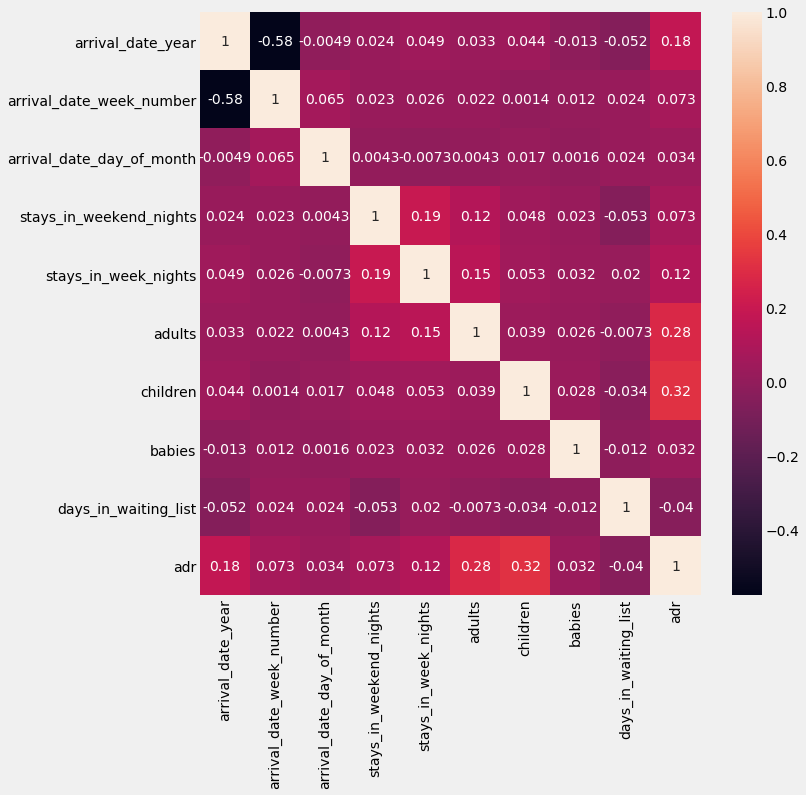

In [11]:
plt.figure(figsize=(10,10))

sns.heatmap(data.corr(), annot=True)

#### Class balance:

In [12]:
data['is_canceled'].value_counts()/len(data)*100  ###: class weight 60-40

0    60.679911
1    39.320089
Name: is_canceled, dtype: float64

This shows the class weight is 60-40 for the new dataset, pretty balanced after the cleaning.

#### Next, we want to encode the categorical columns:

In [13]:
len(data.columns)

28

In [14]:
def encode_columns(column, data):
    
    data = pd.concat([data,pd.get_dummies(data[column],prefix=column)],axis=1)
    data.drop(column, axis=1, inplace=True)
    
    return data


In [15]:
### ------------- encode categorical columns ----------------

categorical_columns = ["hotel", 
                       "arrival_date_year",
                       "arrival_date_month",
                       "meal",
                       "country",
                       "market_segment",
                       "distribution_channel",
                       "deposit_type",
                       "customer_type",
                       "reserved_room_type",
                       "assigned_room_type"
                      ]
    
for col in categorical_columns:
    data=encode_columns(col,data)
    

In [16]:
len(data.columns)

244

In [17]:
# drop columns not used
data.drop('arrival_date_week_number', axis=1, inplace=True)
data.drop('arrival_date_day_of_month', axis=1, inplace=True)

In [18]:
data.head()

,is_canceled,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,days_in_waiting_list,adr,required_car_parking_spaces,right_room,...,assigned_room_type_A,assigned_room_type_B,assigned_room_type_C,assigned_room_type_D,assigned_room_type_E,assigned_room_type_F,assigned_room_type_G,assigned_room_type_H,assigned_room_type_I,assigned_room_type_K
0,0,0,0,2,0.0,0,0,0.0,0.0,1,...,0,0,1,0,0,0,0,0,0,0
1,0,0,0,2,0.0,0,0,0.0,0.0,1,...,0,0,1,0,0,0,0,0,0,0
2,0,0,1,1,0.0,0,0,75.0,0.0,0,...,0,0,1,0,0,0,0,0,0,0
3,0,0,1,1,0.0,0,0,75.0,0.0,1,...,1,0,0,0,0,0,0,0,0,0
4,0,0,2,2,0.0,0,0,98.0,0.0,1,...,1,0,0,0,0,0,0,0,0,0


#### Split the data into train and test sets to evaluate the performance of the models

In [19]:
x = data.drop('is_canceled', axis=1).values
y = data['is_canceled'].values 

In [20]:
x = np.asarray(x)
y = np.asarray(y)

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
# train test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=22)

# Classifiers

#### Let's fit some classifiers on the transformed data set to see how they perform in predicting hotel booking cancellations.

## Decision Tree

In [23]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report,confusion_matrix

In [24]:
# D Tree

dtree = DecisionTreeClassifier(class_weight={0: 0.60, 1:0.4},random_state=22, criterion='entropy')
dtree.fit(x_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight={0: 0.6, 1: 0.4},
                       criterion='entropy', max_depth=None, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       presort='deprecated', random_state=22, splitter='best')

In [25]:
tree_predictions = dtree.predict(x_test)

In [26]:
print(classification_report(y_test,tree_predictions))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88     16116
           1       0.82      0.82      0.82     10638

    accuracy                           0.86     26754
   macro avg       0.85      0.85      0.85     26754
weighted avg       0.86      0.86      0.86     26754



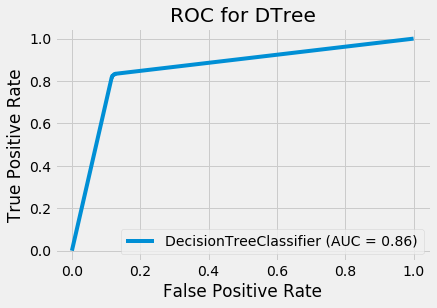

In [27]:
from sklearn.metrics import  plot_roc_curve
plot_roc_curve(dtree, x_test, y_test)
plt.title("ROC for DTree")
plt.show()

#### Cross-validation for decision tree 

In [28]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale, StandardScaler
from sklearn.model_selection import cross_validate, StratifiedKFold, KFold

In [29]:
###### pipeline Decision Tree with CV

In [30]:
pipe_dtree = make_pipeline(StandardScaler(), 
                           dtree)

In [31]:
CV_dtree=cross_validate(pipe_dtree,x_train,y_train,scoring=["accuracy","recall","precision"],
                      cv=StratifiedKFold(n_splits=5))

In [32]:
CV_dtree

{'fit_time': array([2.80340695, 2.57840419, 2.53574491, 2.6880939 , 2.53668261]),
 'score_time': array([0.11732388, 0.10949802, 0.10455441, 0.10668135, 0.10508537]),
 'test_accuracy': array([0.85721405, 0.85304012, 0.84973835, 0.85272863, 0.85391229]),
 'test_recall': array([0.81361323, 0.8134542 , 0.8120229 , 0.81329517, 0.81456743]),
 'test_precision': array([0.82039769, 0.81177591, 0.80587121, 0.81123096, 0.81288684])}

In [33]:
print("The mean accuracy in the Cross-Validation is: {:.2f}%".format((np.mean(CV_dtree["test_accuracy"])*100)))

The mean accuracy in the Cross-Validation is: 85.33%


## Random Forest

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [35]:
randf = RandomForestClassifier(class_weight={0: 0.60, 1:0.4}, random_state=22, criterion="entropy")

randf.fit(x_train, y_train)

randf_prediction=randf.predict(x_test)

accuracy_score(y_pred = randf_prediction, y_true= y_test)

0.8889511848695523

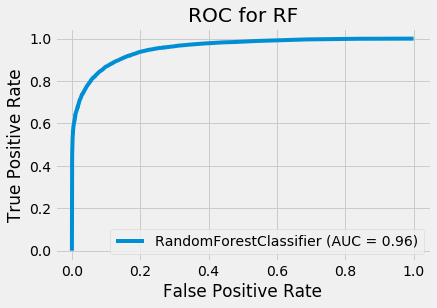

In [36]:
from sklearn.metrics import  plot_roc_curve
plot_roc_curve(randf, x_test, y_test)
plt.title("ROC for RF")
plt.show()

#### Cross-validation for random forest

In [37]:
pipe_randf=make_pipeline(StandardScaler(), randf)

In [38]:
CV_randf=cross_validate(pipe_randf,x_train,y_train,scoring=["accuracy","recall","precision"],
                      cv=StratifiedKFold(n_splits=5))

In [39]:
CV_randf

{'fit_time': array([12.61897993, 12.59276819, 12.51947808, 12.7382257 , 15.02321196]),
 'score_time': array([0.5353539 , 0.53901196, 0.54801774, 0.53569889, 0.54140306]),
 'test_accuracy': array([0.88811363, 0.88144779, 0.88337902, 0.88612011, 0.88524794]),
 'test_recall': array([0.81377226, 0.80629771, 0.81424936, 0.81409033, 0.81711196]),
 'test_precision': array([0.89115291, 0.88097307, 0.87912088, 0.88594669, 0.8813036 ])}

In [40]:
print("The mean accuracy in the Random Forrest is: {:.2f}%".format((np.mean(CV_randf["test_accuracy"])*100)))

The mean accuracy in the Random Forrest is: 88.49%


#### The random forest performs the best so far with good results:

In [41]:
print(classification_report(y_test,randf_prediction))

              precision    recall  f1-score   support

           0       0.89      0.93      0.91     16116
           1       0.89      0.82      0.86     10638

    accuracy                           0.89     26754
   macro avg       0.89      0.88      0.88     26754
weighted avg       0.89      0.89      0.89     26754



## NN

In [42]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten, Dropout
from keras.layers.embeddings import Embedding
from keras.layers import LSTM, Bidirectional
from keras import optimizers
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.layers import Layer

from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics

from scipy.stats import zscore

Using TensorFlow backend.


In [ ]:
#--------- transform the cleaned data set and prepare it to fit the NN

In [44]:
data=data_cleaned

In [45]:
# drop unused columns
data = data.drop(['arrival_date_week_number', 'arrival_date_day_of_month'], axis=1 )

In [46]:
### ------------- encode categorical columns ----------------

categorical_columns = ["required_car_parking_spaces",
                       "right_room",
                       "far_in_advance",
                       "recent_booking",
                       "changed_booking",
                       "previous_cancel",
                       "special_requests",
    
    
                       "hotel", 
                       "arrival_date_year",
                       "arrival_date_month",
                       "meal",
                       "country",
                       "market_segment",
                       "distribution_channel",
                       "deposit_type",
                       "customer_type",
                       "reserved_room_type",
                       "assigned_room_type"
                      ]
    
for col in categorical_columns:
    data=encode_columns(col,data)

In [47]:
data['adr'] = zscore(data['adr'])

In [48]:
data = data.dropna()

In [49]:
data.dtypes

is_canceled                category
stays_in_weekend_nights       int64
stays_in_week_nights          int64
adults                        int64
children                    float64
                             ...   
assigned_room_type_F          uint8
assigned_room_type_G          uint8
assigned_room_type_H          uint8
assigned_room_type_I          uint8
assigned_room_type_K          uint8
Length: 249, dtype: object

In [51]:
x = data.drop('is_canceled', axis=1)
y = data['is_canceled']

In [52]:
print(len(x), len(y))

107014 107014


In [53]:
x = np.asarray(x)
y = np.asarray(y)

In [54]:
# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

model = Sequential()
model.add(Dense(100, input_dim=x.shape[1], activation='relu', kernel_initializer='random_normal'))
model.add(Dropout(0.5))
model.add(Dense(50,activation='relu',kernel_initializer='random_normal'))
model.add(Dropout(0.2))
model.add(Dense(25,activation='relu',kernel_initializer='random_normal'))
model.add(Dense(1,activation='sigmoid', kernel_initializer='random_normal'))


# compile the model
#sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())


monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=12, 
                        verbose=1, mode='auto', restore_best_weights=True)


history = model.fit(x_train, y_train, validation_split=0.2, callbacks=[monitor], verbose=1, epochs=100)

loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
print('Accuracy: %f' % (accuracy*100))
print('\n')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               24900     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 26        
Total params: 31,251
Trainable params: 31,251
Non-trainable params: 0
__________________________________________________

Epoch 48/100
64208/64208 [==============================] - 4s 55us/step - loss: 0.2577 - accuracy: 0.8854 - val_loss: 0.2765 - val_accuracy: 0.8750
Epoch 49/100
64208/64208 [==============================] - 4s 56us/step - loss: 0.2570 - accuracy: 0.8843 - val_loss: 0.2780 - val_accuracy: 0.8765
Epoch 50/100
64208/64208 [==============================] - 4s 55us/step - loss: 0.2570 - accuracy: 0.8830 - val_loss: 0.2774 - val_accuracy: 0.8735
Epoch 51/100
64208/64208 [==============================] - 3s 54us/step - loss: 0.2572 - accuracy: 0.8832 - val_loss: 0.2770 - val_accuracy: 0.8755
Epoch 52/100
64208/64208 [==============================] - 3s 53us/step - loss: 0.2566 - accuracy: 0.8827 - val_loss: 0.2762 - val_accuracy: 0.8745
Epoch 53/100
64208/64208 [==============================] - 4s 56us/step - loss: 0.2557 - accuracy: 0.8841 - val_loss: 0.2740 - val_accuracy: 0.8763
Restoring model weights from the end of the best epoch
Epoch 00053: early stopping
26754/26754 [==========

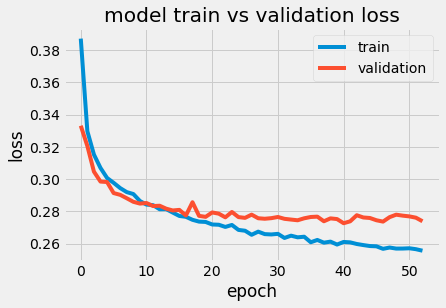

In [55]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [56]:
from sklearn.metrics import roc_curve, auc


# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, _ = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(7,7))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

In [57]:
prediction_proba = model.predict(x_test)

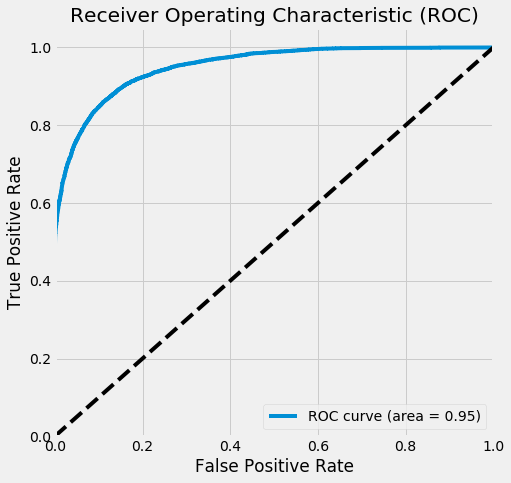

In [58]:
plot_roc(prediction_proba,y_test)